# 5. Curl-Div operator

We consider the following differential operator, in its strong form, on the unit square or cube $\Omega$:

$$
\mathcal{L}^{\alpha, \beta} \mathbf{u} := \alpha \nabla \times \nabla \mathbf{u} - \beta \nabla (\nabla \cdot \mathbf{u})
$$

where $\mathbf{u}$ is supposed to be in $H^1(\Omega)$ (or $H_0^1(\Omega)$).

For our experiments, we will set $\alpha = 1$.

In [14]:
# needed imports
from numpy import linspace, meshgrid, pi, zeros

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Math

from sympy.core.containers import Tuple
from sympy import symbols
from sympy import Symbol
from sympy import Lambda
from sympy import IndexedBase

from gelato.glt import glt_symbol
from gelato.glt import glt_lambdify
from gelato.glt import glt_approximate_eigenvalues
from gelato.printing.latex import glt_latex
from gelato.calculus   import (Dot, Cross, Grad, Curl, Rot, Div)
from gelato.fem.assembly import assemble_matrix
from gelato.fem.utils    import compile_kernel

from spl.fem.splines import SplineSpace
from spl.fem.tensor  import TensorSpace
from spl.fem.vector  import VectorFemSpace

## 2-D case

The weak formulation writes:

$$
a(\mathbf{v},\mathbf{u}) = \int_{\Omega} \alpha \left( \mathrm{rot}~ \mathbf{v} \right)  \left( \mathrm{rot}~ \mathbf{u} \right) + \beta \left( \nabla \cdot \mathbf{v} \right) \left( \nabla \cdot \mathbf{u} \right) ~d\Omega
$$

In [2]:
x,y = symbols('x y')

u = IndexedBase('u')
v = IndexedBase('v')

alpha = Symbol('alpha')
beta = Symbol('beta')

a = Lambda((x,y,v,u), alpha * Rot(v) * Rot(u) + beta * Div(v) * Div(u))

In [3]:
# ...  create a finite element space
p1  = 3 ; p2  = 3
ne1 = 32 ; ne2 = 32

grid_1 = linspace(0., 1., ne1+1)
grid_2 = linspace(0., 1., ne2+1)

V1 = SplineSpace(p1, grid=grid_1)
V2 = SplineSpace(p2, grid=grid_2)

V = TensorSpace(V1, V2)
# ...

# ... create a vector fem space
V = VectorFemSpace(V, V)
# ...

Let's first compute the GLT-symbol, without evaluating it *symbolicaly*:

In [4]:
symbol = glt_symbol(a, space=V, evaluate=False)

Math(glt_latex(symbol))

<IPython.core.display.Math object>

In [5]:
# TODO
#d_constants = {'alpha': 1.}
#d_types = {'beta': 'double'}

d_constants = {'alpha': 1., 'beta': 1.e-3}
d_types = None

We define the FEM kernel, needed to assemble the associated matrix

In [6]:
kernel_f90 = compile_kernel('kernel_2d', a, V,
                            d_constants=d_constants,
                            d_args=d_types,
                            backend='fortran')

For our experiment, we will use the following value for $\beta$

In [8]:
# TODO
#d_args = {'beta': 1.e-3}
d_args = None

We assemble the FEM matrix

In [9]:
M = assemble_matrix(V, kernel_f90, args=d_args)


In [10]:
M

[[<spl.linalg.stencil.StencilMatrix at 0x7fabef83ce48>,

In [11]:
from scipy.sparse import coo_matrix

def coo_from_blocks(matrices, n_block_rows, n_block_cols):

    # ... compute the global nnz
    nnz = 0
    for i in range(0, n_block_rows):
        for j in range(0, n_block_cols):
            nnz += matrices[i][j].nnz
    # ...

    # ... compute number of rows and cols per block
    n_rows = zeros(n_block_rows, dtype=int)
    n_cols = zeros(n_block_cols, dtype=int)

    for i in range(0, n_block_rows):
        n = 0
        for j in range(0, n_block_cols):
            if not(matrices[i][j] is None):
                n = matrices[i][j].shape[0]
                break
        if n == 0:
            raise ValueError('at least one block must be non empty per row')
        n_rows[i] = n

    for j in range(0, n_block_cols):
        n = 0
        for i in range(0, n_block_rows):
            if not(matrices[i][j] is None):
                n = matrices[i][j].shape[1]
                break
        if n == 0:
            raise ValueError('at least one block must be non empty per col')
        n_cols[j] = n
    # ...

    # ...
    data = zeros(nnz)
    rows = zeros(nnz, dtype=int)
    cols = zeros(nnz, dtype=int)
    # ...

    # ...
    n = 0
    for ir in range(0, n_block_rows):
        for ic in range(0, n_block_cols):
            if not(matrices[ir][ic] is None):
                A = matrices[ir][ic]

                n += A.nnz

                shift_row = 0
                if ir > 0:
                    shift_row = sum(n_rows[:ir])

                shift_col = 0
                if ic > 0:
                    shift_col = sum(n_cols[:ic])

                rows[n-A.nnz:n] = A.row[:] + shift_row
                cols[n-A.nnz:n] = A.col[:] + shift_col
                data[n-A.nnz:n] = A.data
    # ...

    # ...
    nr = n_rows.sum()
    nc = n_cols.sum()

    coo = coo_matrix((data, (rows, cols)), shape=(nr, nc))
    coo.eliminate_zeros()
    # ...

    return coo


In [16]:
n_block_rows = 2 ; n_block_cols = 2
matrices = []
for ir in range(0, n_block_rows):
    line = []
    for ic in range(0, n_block_cols):
        line.append(M[ir][ic].tocoo())
    matrices.append(line)
_M = M    
M = coo_from_blocks(matrices, 
                    n_block_rows=2, 
                    n_block_cols=2)

We compute the eigenvalues, using *Lapack*

In [17]:
# import eigenvalue solver
from scipy.linalg import eig

M = M.todense()
w, v = eig(M)
wr = w.real
wr.sort()

We now evaluate oyr symbol, to prepare for the classical comparison with the FEM matrix

In [19]:
symbol = glt_symbol(a, space=V, evaluate=True)

# ... lambdify the glt symbol
# TODO improve
symbol = symbol.subs(d_constants)
#symbol = symbol.subs(d_args)
# ...

Sampling the GLT symbol in the Fourier space, is done as usual by calling:

In [20]:
eig = glt_approximate_eigenvalues(symbol, space=V)
t = eig
t.sort()

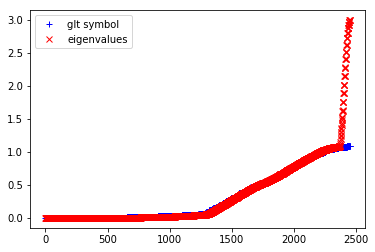

In [21]:
plt.plot(t, "+b", label="glt symbol")
plt.plot(wr, "xr", label="eigenvalues")
plt.legend(loc=2);

## 3-D case

The weak formulation writes:

$$
a(\mathbf{v},\mathbf{u}) = \int_{\Omega} \alpha \left( \nabla \times \mathbf{v} \right)  \left( \nabla \times \mathbf{u} \right) + \beta \left( \nabla \cdot \mathbf{v} \right) \left( \nabla \cdot \mathbf{u} \right) ~d\Omega
$$

In [22]:
x,y,z = symbols('x y z')

u = IndexedBase('u')
v = IndexedBase('v')

alpha = Symbol('alpha')
beta = Symbol('beta')

a = Lambda((x,y,z,v,u), alpha * Dot(Curl(u), Curl(v)) + beta * Div(v) * Div(u))

In [23]:
# ...  create a finite element space
p1  = 2 ; p2  = 2 ; p3  = 2
ne1 = 8 ; ne2 = 8 ; ne3 = 8

grid_1 = linspace(0., 1., ne1+1)
grid_2 = linspace(0., 1., ne2+1)
grid_3 = linspace(0., 1., ne3+1)

V1 = SplineSpace(p1, grid=grid_1)
V2 = SplineSpace(p2, grid=grid_2)
V3 = SplineSpace(p3, grid=grid_3)

Vs = TensorSpace(V1, V2, V3)
# ...

V = VectorFemSpace(Vs, Vs, Vs)

Let's first compute the GLT symbol and print it

In [24]:
symbol = glt_symbol(a, space=V, evaluate=False)

Math(glt_latex(symbol))

<IPython.core.display.Math object>

In [5]:
d_constants = {'alpha': 1.}
d_types = {'beta': 'double'}

In [ ]:
# TODO
kernel_f90 = compile_kernel('kernel_3d', a, V,
                            d_constants=d_constants,
                            d_args=d_types,
                            backend='fortran')

In [6]:
d_args = {'beta': 1.e-3}

In [ ]:
# TODO
M = assemble_matrix(V, kernel_f90, args=d_args).tocsr()

In [ ]:
# TODO
# import eigenvalue solver
from scipy.linalg import eig

M = M.todense()
w, v = eig(M)
wr = w.real
wr.sort()

In [7]:
symbol = glt_symbol(a, space=V, evaluate=True)

# ... lambdify the glt symbol
# TODO improve
symbol = symbol.subs(d_constants)
symbol = symbol.subs(d_args)
# ...

In [8]:
eig = glt_approximate_eigenvalues(symbol, space=V)
t = eig
t.sort()

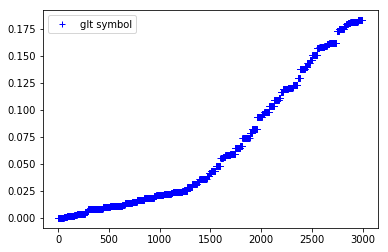

In [9]:
plt.plot(t, "+b", label="glt symbol")
#plt.plot(wr, "xr", label="eigenvalues")
plt.legend(loc=2);

In [13]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()